In [1]:
import numpy as np
from lel_ws import LEL_WS
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from joblib import Parallel, delayed
import os
from datetime import datetime
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from IPython.display import display

In [2]:
def generate_data(N, mu, sigma2, pi, contam_mean=10):
    n_contam = int(N * pi)
    n_clean = N - n_contam
    data_clean = np.random.normal(loc=mu, scale=np.sqrt(sigma2), size=n_clean)
    data_contam = np.random.normal(loc=contam_mean, scale=1.0, size=n_contam)
    return np.sort(np.concatenate([data_clean, data_contam]))

In [3]:
def neg_log_lel_ws(params, x, lambda_param):
    mu, log_sigma2 = params
    sigma2 = np.exp(log_sigma2)  # ensures sigma² > 0
    out = LEL_WS(x, mu, sigma2, lambda_param)
    print(f"Trying mu={mu:.4f}, sigma²={sigma2:.4f}, LEL_WS={out['Optimal_Value']:.4f}")
    return -out["Optimal_Value"]  # negate for minimization

In [4]:
mu_grid     = np.linspace(-0.5, 1.5, 10)
sigma2_grid = np.linspace(0.5, 6.0, 10)
epsilon_list = [0.01, 0.1, 0.25, 0.5]

# Store results: stored_results[pi][epsilon] = (raw_results, best_mu, best_sigma2)
stored_results = {pi: {} for pi in [0.0, 0.01, 0.2]}

for epsilon in epsilon_list:
    lambda_param = 1 / epsilon
    print(f"\n========================")
    print(f"Running for ε = {epsilon:.4f} (λ = {lambda_param:.2f})")

    for pi in [0.0, 0.01, 0.2]:
        print(f"\n--- π = {pi} ---")

        # Generate contaminated data
        x = generate_data(N=100, mu=0, sigma2=1, pi=pi, contam_mean=5)
        param_grid = [(mu, sigma2) for mu in mu_grid for sigma2 in sigma2_grid]

        # Log file for this setting
        log_file = f"lel_log_eps_{epsilon:.2f}_pi_{pi:.2f}.txt"
        if os.path.exists(log_file):
            os.remove(log_file)

        # Evaluation function
        def eval_lel(mu, sigma2):
            now = datetime.now().strftime("%H:%M:%S")
            try:
                result = LEL_WS(x, mu, sigma2, lambda_param)
                value = result["Optimal_Value"]
            except Exception as e:
                value = -np.inf
                with open(log_file, "a", encoding="utf-8") as f:
                    f.write(f"[{now}] FAIL  mu={mu:.2f}, sigma2={sigma2:.2f}, error: {str(e)}\n")
            else:
                if np.random.rand() < 0.1:
                    with open(log_file, "a", encoding="utf-8") as f:
                        f.write(f"[{now}] OK    mu={mu:.2f}, sigma2={sigma2:.2f}, LEL={value:.4f}\n")
            return (mu, sigma2, value)

        # Run grid
        raw_results = Parallel(n_jobs=-1, verbose=0)(
            delayed(eval_lel)(mu, sigma2) for (mu, sigma2) in param_grid
        )

        # Parse and store best
        filtered_results = [(mu, sigma2, val) for (mu, sigma2, val) in raw_results if np.isfinite(val)]
        if filtered_results:
            best_mu, best_sigma2, best_val = max(filtered_results, key=lambda x: x[2])
            print(f"BEST RESULT for π = {pi}, ε = {epsilon:.4f}")
            print(f"  μ̂ = {best_mu:.4f}")
            print(f"  σ̂² = {best_sigma2:.4f}")
            print(f"  LEL = {best_val:.4f}")

            stored_results[pi][epsilon] = (raw_results, best_mu, best_sigma2)
        else:
            print(f"All evaluations failed for π = {pi}, ε = {epsilon:.4f}")


Running for ε = 0.0100 (λ = 100.00)

--- π = 0.0 ---
BEST RESULT for π = 0.0, ε = 0.0100
  μ̂ = 0.1667
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.01 ---
BEST RESULT for π = 0.01, ε = 0.0100
  μ̂ = 0.1667
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.2 ---
BEST RESULT for π = 0.2, ε = 0.0100
  μ̂ = 1.0556
  σ̂² = 2.3333
  LEL = -460.5171

Running for ε = 0.1000 (λ = 10.00)

--- π = 0.0 ---
BEST RESULT for π = 0.0, ε = 0.1000
  μ̂ = -0.0556
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.01 ---
BEST RESULT for π = 0.01, ε = 0.1000
  μ̂ = -0.0556
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.2 ---
BEST RESULT for π = 0.2, ε = 0.1000
  μ̂ = 1.0556
  σ̂² = 2.9444
  LEL = -460.5170

Running for ε = 0.2500 (λ = 4.00)

--- π = 0.0 ---
BEST RESULT for π = 0.0, ε = 0.2500
  μ̂ = -0.2778
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.01 ---
BEST RESULT for π = 0.01, ε = 0.2500
  μ̂ = -0.2778
  σ̂² = 1.1111
  LEL = -460.5170

--- π = 0.2 ---
BEST RESULT for π = 0.2, ε = 0.2500
  μ̂ = 1.0556
  σ̂² = 2.3333


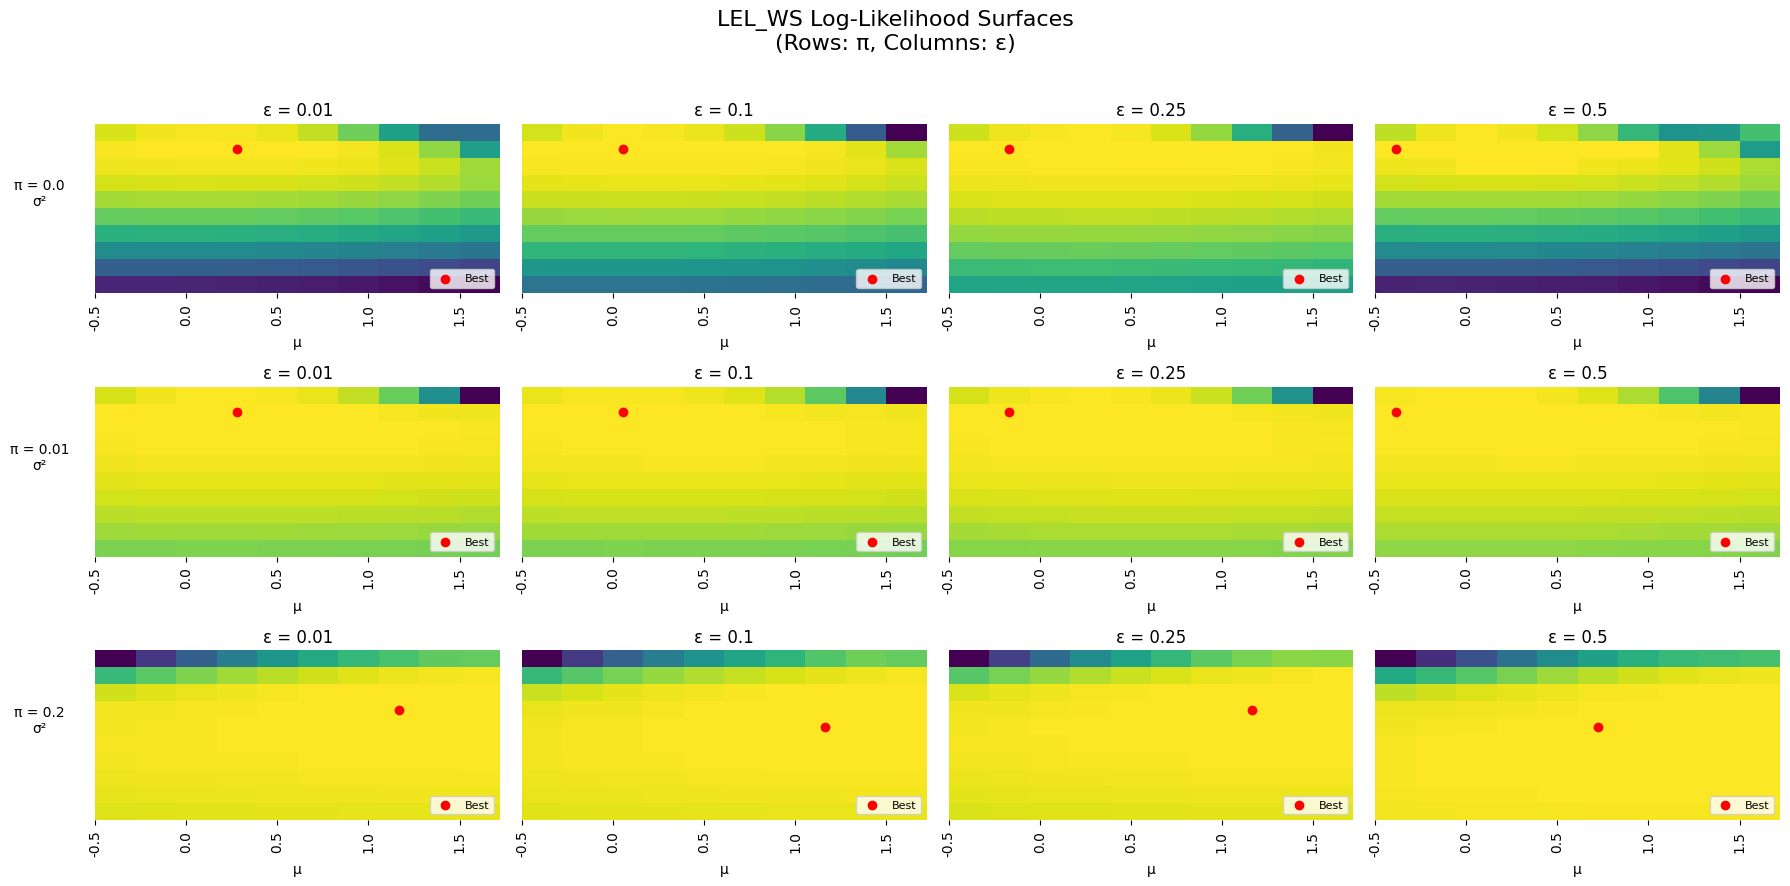

In [5]:
pi_list = [0.0, 0.01, 0.2]

fig, axes = plt.subplots(len(pi_list), len(epsilon_list), figsize=(18, 9), sharey=True)

for row, pi in enumerate(pi_list):
    for col, epsilon in enumerate(epsilon_list):
        ax = axes[row, col]

        if epsilon not in stored_results[pi]:
            ax.set_visible(False)
            continue

        raw_results, best_mu, best_sigma2 = stored_results[pi][epsilon]

        # Build log-likelihood grid
        log_likelihood_grid = np.full((len(mu_grid), len(sigma2_grid)), -np.inf)
        for mu, sigma2, val in raw_results:
            i = np.argmin(np.abs(mu_grid - mu))
            j = np.argmin(np.abs(sigma2_grid - sigma2))
            log_likelihood_grid[i, j] = val

        # Locate best point
        i_best = np.argmin(np.abs(mu_grid - best_mu))
        j_best = np.argmin(np.abs(sigma2_grid - best_sigma2))

        # Plot heatmap
        sns.heatmap(log_likelihood_grid.T, cmap="viridis",
                    xticklabels=np.round(mu_grid, 2),
                    yticklabels=np.round(sigma2_grid, 2),
                    cbar=False, ax=ax)

        ax.set_title(f"ε = {epsilon}")
        ax.set_xticks(np.linspace(0, len(mu_grid)-1, 5))
        ax.set_xticklabels(np.round(np.linspace(mu_grid[0], mu_grid[-1], 5), 2))

        if col == 0:
            ax.set_yticks(np.linspace(0, len(sigma2_grid)-1, 5))
            ax.set_yticklabels(np.round(np.linspace(sigma2_grid[0], sigma2_grid[-1], 5), 2))
            ax.set_ylabel(f"π = {pi}\nσ²", rotation=0, labelpad=40)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        ax.set_xlabel("μ")
        ax.scatter(i_best + 0.5, j_best + 0.5, color='red', marker='o', label='Best')
        ax.legend(loc="lower right", fontsize=8)

plt.suptitle("LEL_WS Log-Likelihood Surfaces\n(Rows: π, Columns: ε)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

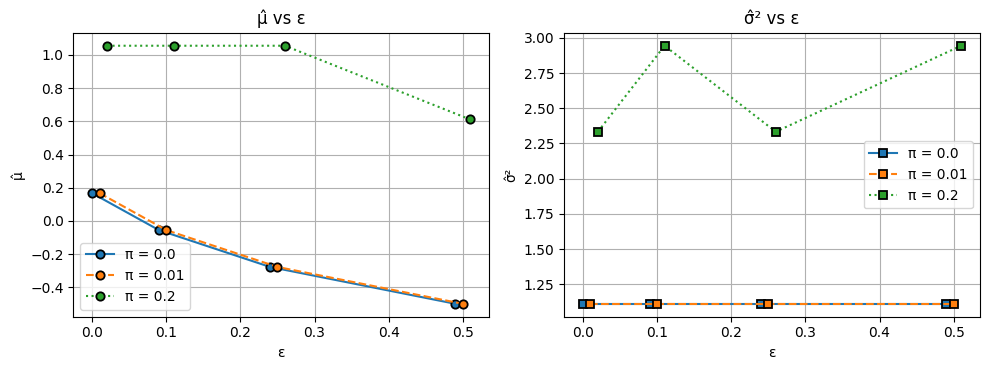

In [6]:
mu_results = {}
sigma2_results = {}

linestyles = {0.0: 'solid', 0.01: 'dashed', 0.2: 'dotted'}
epsilon_offset = {0.0: -0.01, 0.01: 0.0, 0.2: 0.01}

# Build result dictionaries from stored_results
for pi in stored_results:
    mu_results[pi] = []
    sigma2_results[pi] = []
    for epsilon in sorted(stored_results[pi]):
        _, mu_hat, sigma2_hat = stored_results[pi][epsilon]
        mu_results[pi].append((epsilon, mu_hat))
        sigma2_results[pi].append((epsilon, sigma2_hat))

# --- Combined Plot: μ̂ vs ε and σ̂² vs ε ---
fig, axes = plt.subplots(1, 2, figsize=(10, 3.8), sharex=True)

# --- μ̂ vs ε ---
for pi, data in mu_results.items():
    epsilons, mus = zip(*sorted(data))
    eps_shifted = [e + epsilon_offset[pi] for e in epsilons]
    axes[0].plot(eps_shifted, mus, marker='o', markersize=6, markeredgewidth=1.3,
                 markeredgecolor='black', linestyle=linestyles[pi], label=f"π = {pi}")
axes[0].set_title("μ̂ vs ε")
axes[0].set_xlabel("ε")
axes[0].set_ylabel("μ̂")
axes[0].grid(True)
axes[0].legend()

# --- σ̂² vs ε ---
for pi, data in sigma2_results.items():
    epsilons, sigmas = zip(*sorted(data))
    eps_shifted = [e + epsilon_offset[pi] for e in epsilons]
    axes[1].plot(eps_shifted, sigmas, marker='s', markersize=6, markeredgewidth=1.3,
                 markeredgecolor='black', linestyle=linestyles[pi], label=f"π = {pi}")
axes[1].set_title("σ̂² vs ε")
axes[1].set_xlabel("ε")
axes[1].set_ylabel("σ̂²")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [7]:
# Round and prepare values as strings
formatted_data = {}

for pi in sorted(stored_results):
    row = {}
    for epsilon in sorted(stored_results[pi]):
        _, mu_hat, sigma2_hat = stored_results[pi][epsilon]
        mu_str = f"{mu_hat:.3f}"
        sigma2_str = f"{sigma2_hat:.3f}"
        row[f"{epsilon:.2f}"] = f"({mu_str}, {sigma2_str})"
    formatted_data[f"{pi:.2f}"] = row

# Convert to DataFrame
df_matrix = pd.DataFrame.from_dict(formatted_data, orient="index")
df_matrix.index.name = "π"
df_matrix.columns.name = "ε"

# Display cleanly
display(df_matrix)

ε,0.01,0.10,0.25,0.50
π,,,,
0.00,"(0.167, 1.111)","(-0.056, 1.111)","(-0.278, 1.111)","(-0.500, 1.111)"
0.01,"(0.167, 1.111)","(-0.056, 1.111)","(-0.278, 1.111)","(-0.500, 1.111)"
0.20,"(1.056, 2.333)","(1.056, 2.944)","(1.056, 2.333)","(0.611, 2.944)"


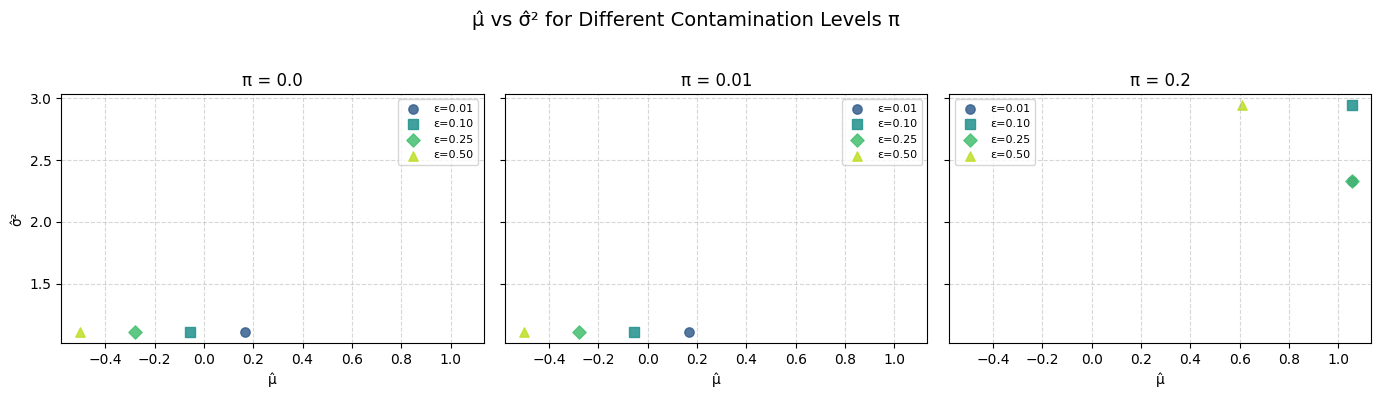

In [8]:
# --- μ̂ vs σ̂² for each π in one row ---
points = []
for pi in stored_results:
    for epsilon in stored_results[pi]:
        _, mu_hat, sigma2_hat = stored_results[pi][epsilon]
        points.append((pi, epsilon, mu_hat, sigma2_hat))
points.sort()

# Marker styles and colors for different ε values
epsilons = sorted(set(eps for _, eps, _, _ in points))
marker_styles = {eps: m for eps, m in zip(epsilons, ["o", "s", "D", "^", "v", "X", "P"])}
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(epsilons)))

# Setup subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
pi_list = sorted(stored_results.keys())

for idx, pi in enumerate(pi_list):
    ax = axes[idx]
    for (pi_val, epsilon, mu_hat, sigma2_hat) in points:
        if pi_val != pi:
            continue
        ax.scatter(mu_hat, sigma2_hat,
                   color=colors[epsilons.index(epsilon)],
                   marker=marker_styles[epsilon],
                   s=45, alpha=0.85,
                   label=f"ε={epsilon:.2f}")
    ax.set_title(f"π = {pi}")
    ax.set_xlabel("μ̂")
    if idx == 0:
        ax.set_ylabel("σ̂²")
    ax.grid(True, linestyle="--", alpha=0.5)

    # De-duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), fontsize=8, loc='best')

plt.suptitle("μ̂ vs σ̂² for Different Contamination Levels π", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()